<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
#pip install statsmodels

In [2]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# metrics

def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [8]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [9]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



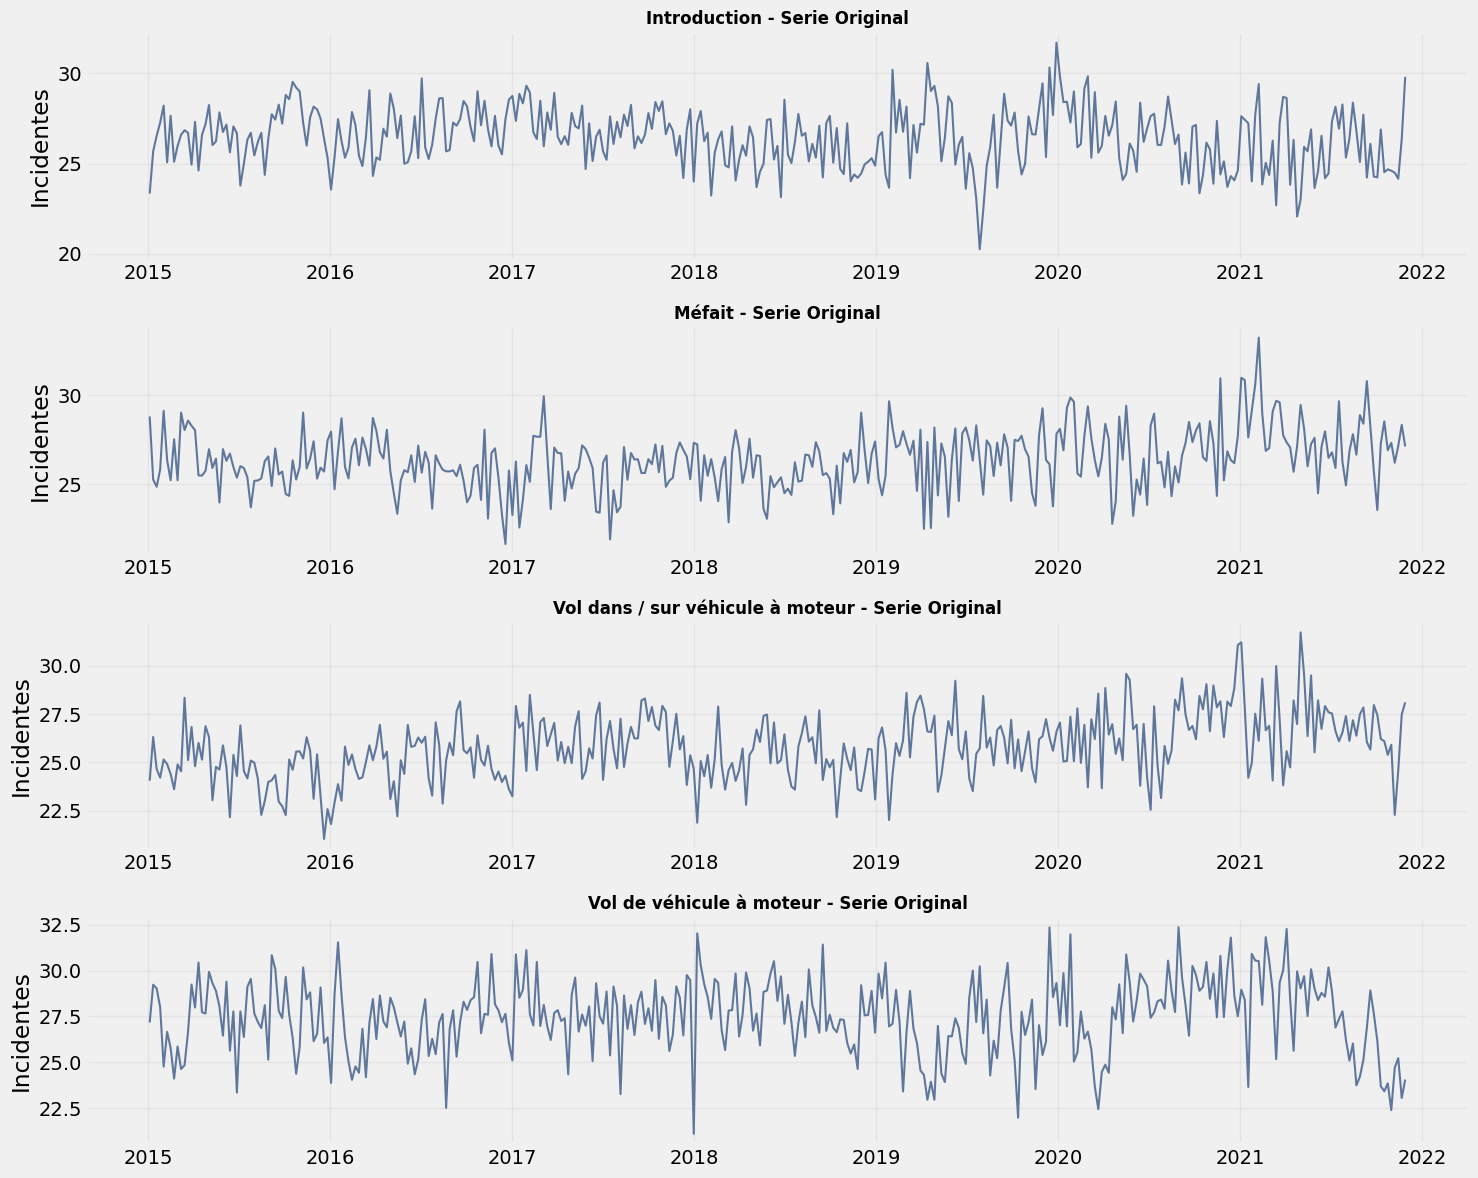

In [10]:
# Análisis de componentes para cada serie
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

series_list = [y_s1, y_s2, y_s3, y_s4]
titles = validate_categorie

for i, (series, title) in enumerate(zip(series_list, titles)):
    
    axes[i].plot(series.index, series['pdq'], linewidth=1.5)
    axes[i].set_title(f'{title} - Serie Original', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Incidentes')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print("Estadisticas:")

for i, (series, categoria) in enumerate(zip([y_s1, y_s2, y_s3, y_s4], validate_categorie)):
    
    print(f"\n{categoria}:")
    print(f"  - Período: {series.index.min()} a {series.index.max()}")
    print(f"  - Total de semanas: {len(series)}")
    print(f"  - Media: {series['pdq'].mean():.2f}")
    print(f"  - Desviación estándar: {series['pdq'].std():.2f}")
    print(f"  - Máximo: {series['pdq'].max():.2f}")
    print(f"  - Mínimo: {series['pdq'].min():.2f}")

Estadisticas:

Introduction:
  - Período: 2015-01-04 00:00:00 a 2021-11-28 00:00:00
  - Total de semanas: 361
  - Media: 26.44
  - Desviación estándar: 1.66
  - Máximo: 31.70
  - Mínimo: 20.26

Méfait:
  - Período: 2015-01-04 00:00:00 a 2021-11-28 00:00:00
  - Total de semanas: 361
  - Media: 26.39
  - Desviación estándar: 1.68
  - Máximo: 33.22
  - Mínimo: 21.66

Vol dans / sur véhicule à moteur:
  - Período: 2015-01-04 00:00:00 a 2021-11-28 00:00:00
  - Total de semanas: 361
  - Media: 25.79
  - Desviación estándar: 1.71
  - Máximo: 31.73
  - Mínimo: 21.03

Vol de véhicule à moteur:
  - Período: 2015-01-04 00:00:00 a 2021-11-28 00:00:00
  - Total de semanas: 361
  - Media: 27.46
  - Desviación estándar: 2.05
  - Máximo: 32.37
  - Mínimo: 21.09




1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [12]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

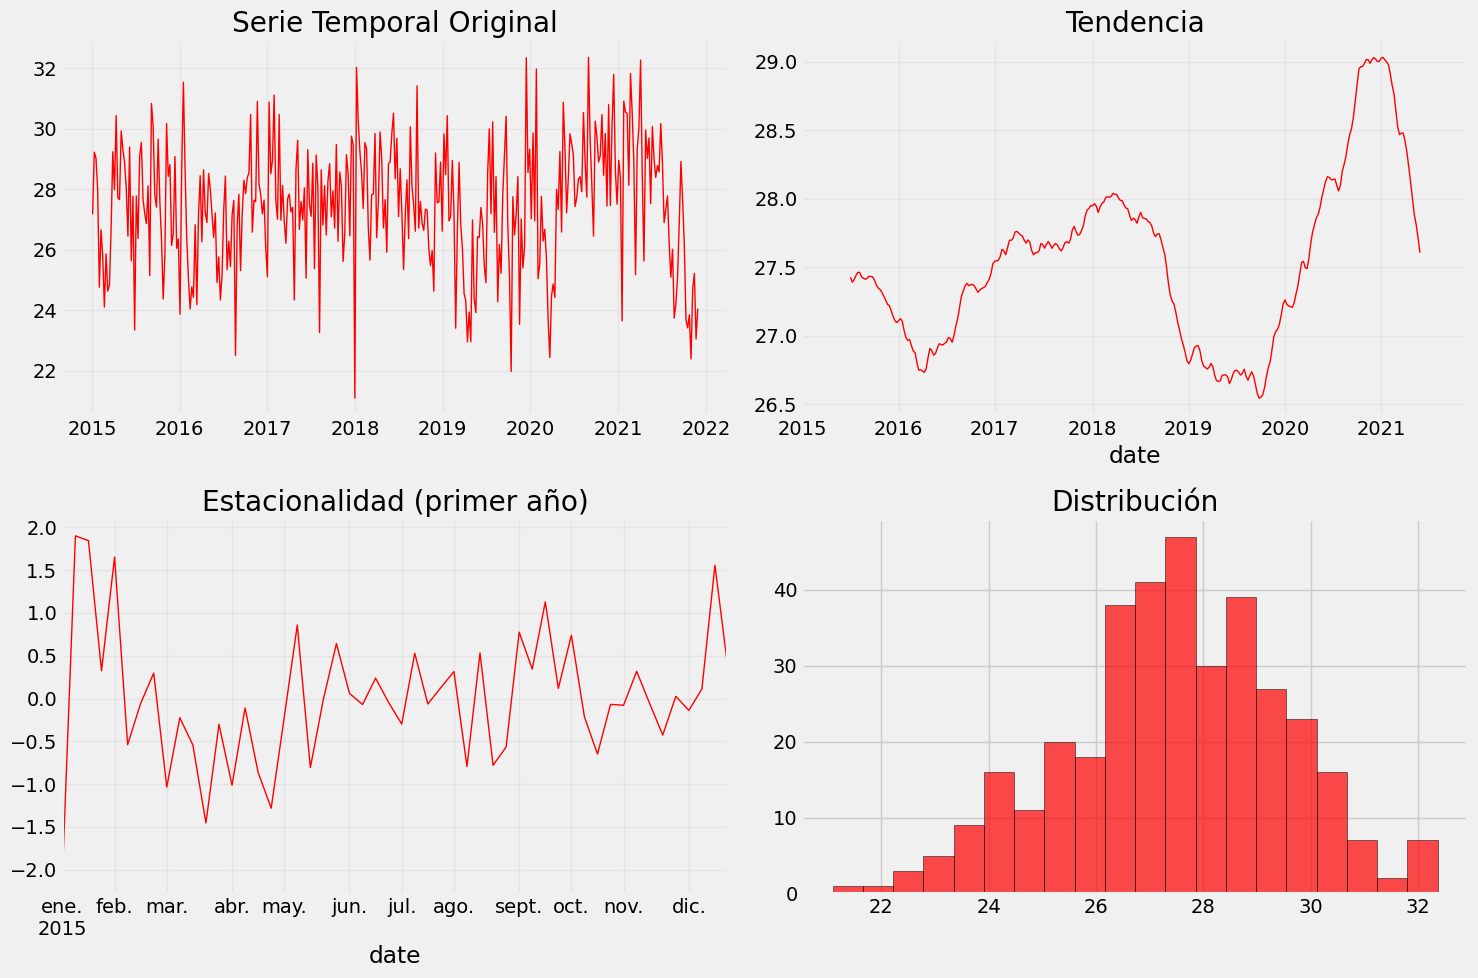

In [19]:
y_series = y_s4.copy()
categoria = validate_categorie[3]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(y_series.index, y_series['pdq'], color='red', linewidth=1)
plt.title('Serie Temporal Original')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
decomposition = sm.tsa.seasonal_decompose(y_series['pdq'].dropna(), model='additive', period=52)
decomposition.trend.plot(color='red', linewidth=1)
plt.title('Tendencia')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
decomposition.seasonal[:52].plot(color='red', linewidth=1)
plt.title('Estacionalidad (primer año)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(y_series['pdq'].dropna(), bins=20, color='red', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title('Distribución')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

parametros_prueba = [
    ((1, 1, 1), (1, 1, 1, 12)),
    ((1, 1, 0), (1, 1, 0, 12)), 
    ((0, 1, 1), (0, 1, 1, 12)),
    ((1, 0, 1), (1, 0, 1, 12))]

resultados = []

for param in parametros_prueba:

    try:

        modelo = SarimaModels(param)
        metricas = modelo.metrics(y_series, '2021-01-01')
        resultados.append(metricas)

    except:

        continue


if resultados:

    df_resultados = pd.concat(resultados, ignore_index=True)
    df_resultados = df_resultados.sort_values('rmse')

    print("COMPARACIÓN DE MODELOS SARIMA:")
    print(df_resultados[['model', 'rmse', 'mape']].to_string(index=False))
    
    mejor_modelo_param = parametros_prueba[df_resultados.index[0]]
    mejor_modelo = SarimaModels(mejor_modelo_param)
    

    modelo_ajustado = mejor_modelo.fit_model(y_series, '2021-01-01')
    residuos = modelo_ajustado.resid
    
    lb_test = acorr_ljungbox(residuos.dropna(), lags=[10], return_df=True)
    
    print(f"\nMEJOR MODELO: {df_resultados['model'].iloc[0]}")
    print(f"RMSE: {df_resultados['rmse'].iloc[0]}")
    print(f"MAPE: {df_resultados['mape'].iloc[0]*100:.2f}%")
    print(f"Test Ljung-Box p-value: {lb_test['lb_pvalue'].iloc[0]:.4f}")
    
    if lb_test['lb_pvalue'].iloc[0] > 0.05:
        print("Los residuos se comportan como ruido blanco")
    else:
        print("Los residuos NO se comportan como ruido blanco")

COMPARACIÓN DE MODELOS SARIMA:
                    model   rmse   mape
SARIMA_(1,1,0)X(1,1,0,12) 2.4514 0.0774
SARIMA_(1,0,1)X(1,0,1,12) 2.6044 0.0817
SARIMA_(1,1,1)X(1,1,1,12) 3.1256 0.0963
SARIMA_(0,1,1)X(0,1,1,12) 3.2508 0.1012

MEJOR MODELO: SARIMA_(1,1,0)X(1,1,0,12)
RMSE: 2.4514
MAPE: 7.74%
Test Ljung-Box p-value: 0.0696
Los residuos se comportan como ruido blanco


3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [15]:
#pip install prophet

In [16]:
from prophet import Prophet

c:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [20]:
y_series = y_s4.copy()
df_prophet = y_series.reset_index()[['date', 'pdq']].rename(columns={'date': 'ds', 'pdq': 'y'}).dropna()

train_mask = df_prophet['ds'] < '2021-01-01'
df_train = df_prophet[train_mask]
df_test = df_prophet[~train_mask]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_train)

future = model_prophet.make_future_dataframe(periods=len(df_test), freq='W')
forecast = model_prophet.predict(future)
forecast_test = forecast[forecast['ds'] >= '2021-01-01']


df_prophet_results = pd.DataFrame({
    'y': df_test['y'].values,
    'yhat': forecast_test['yhat'].values
})

prophet_metrics = summary_metrics(df_prophet_results)
prophet_metrics['model'] = 'Prophet'

01:33:01 - cmdstanpy - INFO - Chain [1] start processing
01:33:01 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
mejor_sarima = SarimaModels(((1, 1, 1), (1, 1, 1, 12)))
df_sarima_results = mejor_sarima.df_testig(y_series, '2021-01-01')
sarima_metrics = summary_metrics(df_sarima_results)
sarima_metrics['model'] = 'SARIMA'

comparison_df = pd.concat([sarima_metrics, prophet_metrics], ignore_index=True)

print("\nMetricas:")
print(comparison_df[['model', 'rmse', 'mae', 'mape']].to_string(index=False))

print(f"\nMEJOR MODELO: {comparison_df.loc[comparison_df['rmse'].idxmin(), 'model']}")


Metricas:
  model   rmse    mae   mape
 SARIMA 3.1256 2.4537 0.0963
Prophet 3.1812 2.5734 0.0997

MEJOR MODELO: SARIMA


El análisis comparativo revela que Prophet ofrece implementación rápida y manejo automatizado de patrones complejos, ideal para proyectos con plazos ajustados o recursos técnicos limitados. SARIMA, aunque requiere mayor expertise y tiempo de ajuste, proporciona control preciso sobre la especificación del modelo y mayor transparencia metodológica. La elección debe basarse en el balance entre eficiencia operacional (Prophet) y precisión estadística (SARIMA), considerando los objetivos específicos del proyecto y los recursos disponibles